## HW 1 : Professionalism & Reproducibility

The goal of this assignment is to construct, analyze, and publish a dataset of monthly article traffic for a select set of pages from English Wikipedia from July 1, 2015 through September 30, 2024. Your notebook(s) and your data files will be uploaded to a repository of your choosing. The purpose of the assignment is to develop and follow best practices for open scientific research as exemplified by this repository.

#### License

Snippets of the below code were taken from a code example developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the Creative [Commons CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.3 - August 16, 2024


In [89]:
# imports
# These are standard python modules
import json, time, urllib.parse, os
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
# Eg. pip install requests
import requests
import pandas as pd

# Import the package for drawing plots.
import matplotlib.pyplot as plt

## STEP 1: DATA AQUISITION

In order to measure article traffic from 2015-2024, you will need to collect data from the Wikimedia Analytics API. The Pageviews API call [(documentation)](https://doc.wikimedia.org/generated-data-platform/aqs/analytics-api/reference/page-views.html) provides access to desktop, mobile web, and mobile app traffic data starting from July 2015 through the previous complete month.

For this assignment, we retrieve details for all articles listed in the provided [CSV](HCDS_HW1/rare-disease_cleaned.AUG.2024.csv) by querying the PageViews API using the article names. The retrieved data is stored in JSON files, where the keys represent the article titles and the values contain the corresponding data obtained from the API.

The code relies on some constants that help make the code a bit more readable. Some values might need to be updated to reflect correct paths/values.


In [92]:
#########
#
#    Constants definition
#
# Local path to the CSV File containing the wikipedia articles of interest. Update this to point to the correct path.
WIKIPEDIA_ARTICLES= './rare-disease_cleaned.AUG.2024.csv'

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
# Replace the email address to your own email 
REQUEST_HEADERS = {
    'User-Agent': '<swarali@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

start_date = "201507"
end_date = "202409"

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015010100",   # start and end dates need to be set
    "end":         "2024093000"    
}

# Creating templates for Mobile App and Mobile web by cloning the desktop template and updating the "access" value.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP["access"] = "mobile-app"

ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP.copy()
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB["access"] = "mobile-web"

The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. Therefore the parameter which will change is the article_title.

In [93]:
#########
#
#    Functions for Data Aquisition
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP,
                                  headers = REQUEST_HEADERS):

    """
    Makes a REST API call to the PageViews endpoint and returns the JSON response.

    Args:
        article_title (str): The title of the article to request pageviews for.
        endpoint_url (str): The URL of the API endpoint.
        endpoint_params (str): The parameters for the API request.
        request_template (dict): The template for the request parameters.
        headers (dict): The headers for the API request.

    Returns:
        dict or None: The JSON response from the API call, or None if an error occurs.
    """
    
    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


def write_to_file(json_data, filename, mode="a+"):
    """
    Writes JSON data to a specified file.

    Args:
        json_data (dict): The JSON data to be written to the file.
        filename (str): The name of the file where the data will be written.
        mode (str, optional): The file mode in which to open the file. Defaults to "a+" 
                              (append and read mode).

    Raises:
        Exception: If an error occurs during the file write operation, it will be caught 
                   and printed.

    Returns:
        None
    """
    try:
        with open(filename, mode) as f:
            json.dump(json_data, f, ensure_ascii=False)
    except Exception as e:
        print(e)


def create_dir_if_not_exists(dest_folder):
    """
    Creates a directory if it does not already exist.

    Args:
        dest_folder (str): The path of the directory to create.

    Raises:
        Exception: If an error occurs while attempting to create the directory,
                   an error message is printed along with the exception details.

    Returns:
        None
    """
    if not os.path.exists(dest_folder):
        try:
            os.makedirs(dest_folder)
        except Exception as e:
            print("Unable to create path: " + dest_folder)
            print(e)


Note: 

The safe='' parameter in the 

`urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')` 

in the `request_pageviews_per_article` function
ensures all characters, including '/', are properly encoded. This modification was necessary to handle article titles containing '/' in the title.

Next we will produce three files as follows:

Monthly mobile access - The API separates mobile access types into two separate requests, you will need to sum these to make one count for all mobile pageviews. You should store the mobile access data in a file called:
rare-disease_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json

Monthly desktop access - Monthly desktop page traffic is based on one single request. You should store the desktop access data in a file called:
rare-disease_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json

Monthly cumulative - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. You should store the monthly cumulative data in a file called:
rare-disease_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json

Note: The following step may take 10-30 mins depending on the system and network available.

In [94]:
# Read the list of wikipedia articles from the CSV file and create a dataframe
wiki_disease_list_df = pd.read_csv(WIKIPEDIA_ARTICLES)

# Order the list by article title, i.e, disease name in the CSV
wiki_disease_list_df = wiki_disease_list_df.sort_values("disease").reset_index(drop=True)

# Create empty dictionaries for each file to be created
desktop_views = {}
mobile_views = {}
cumulative_views = {}

# Start time to check how long does it take to run the loop
start_time = time.time()

# Iterate over the rows at the random indices
for index, row in wiki_disease_list_df.iterrows():

    # Fetch article title from dataframe
    article_title = row["disease"]
    print("--- INFO: Getting pageview data for disease:", article_title, ", index:", index)

    # Get data for desktop access views for the article

    desktop_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_DESKTOP)
    desktop_views_per_title = desktop_views_per_title["items"]
    # Convert JSON to dataframe
    desktop_views_df = pd.DataFrame(desktop_views_per_title)
    # Drop "access" column
    desktop_views_df = desktop_views_df.drop('access', axis=1)
    # Convert dataframe back to JSON Array, and add it to the desktop_views dictionary with article title as the key
    desktop_views[article_title] = json.loads(desktop_views_df.to_json(orient = "records"))
    print("--- LOG: Desktop views added to dictionary with article title as the key")

    # Get data for mobile access views for the article

    # First get data for mobile app access view for the article
    # ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'mobile-app'
    mobile_app_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_APP)
    mobile_app_views_per_title = mobile_app_views_per_title["items"]
    # Convert JSON to dataframe
    mobile_app_views_df = pd.DataFrame(mobile_app_views_per_title)
    # Drop "access" column
    mobile_app_views_df = mobile_app_views_df.drop('access', axis=1)
    # Rename the view column to avoid join issues
    mobile_app_views_df = mobile_app_views_df.rename(columns={"views": "app_views"})

    # Then get data for mobile web access views for the article
    # ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = 'mobile-web'
    mobile_web_views_per_title = request_pageviews_per_article(article_title, request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE_MOBILE_WEB)
    mobile_web_views_per_title = mobile_web_views_per_title["items"]
    # Convert JSON to dataframe
    mobile_web_views_df = pd.DataFrame(mobile_web_views_per_title)
    # Drop "access" column
    mobile_web_views_df = mobile_web_views_df.drop('access', axis=1)
    # Rename the view column to avoid join issues
    mobile_web_views_df = mobile_web_views_df.rename(columns={"views": "web_views"})

    # Merge the Mobile App and Mobile web based on the article name, project, granularity, agent and timestamp. 
    # Then we find a sum of all the page views which were accessed using a mobile.
    mobile_views_df = pd.merge(mobile_app_views_df, mobile_web_views_df, on=["project", "article", "granularity","timestamp", "agent"], how="outer")
    # Total mobile views is calculated by adding the app and web mobile views.
    mobile_views_df["views"] = mobile_views_df["web_views"] + mobile_views_df["app_views"]
    # Drop the access and views columns specific to mobile app and mobile web.
    mobile_views_df = mobile_views_df.drop(["web_views", "app_views"], axis=1)
    # Convert dataframe back to JSON Array, and add it to the mobile_views dictionary with article title as the key
    mobile_views[article_title] = json.loads(mobile_views_df.to_json(orient = "records"))
    print("--- LOG: All Mobile views added to dictionary")

    # Get data for cummulative views for the article

    # To find the cummulative views of articles accross desktop and mobile we merge these two dataframes created above and 
    # sum the views. We will join them on the following article name, project, granularity, agent and timestamp. 
    cumulative_views_df = pd.merge(desktop_views_df, mobile_views_df, on=["project", "article", "granularity","timestamp", "agent"], how="outer")
    cumulative_views_df["views"] = cumulative_views_df["views_x"] + cumulative_views_df["views_y"]
    # Drop the views columns specific to desktop and mobile views dataframes.
    cumulative_views_df = cumulative_views_df.drop(["views_x", "views_y"], axis=1)
    # Convert dataframe back to JSON Array, and add it to the cumulative_views dictionary with article title as the key
    cumulative_views[article_title] = json.loads(cumulative_views_df.to_json(orient = "records"))
    print("--- LOG: Cumulative views added to dictionary")

    print("--------------------------------------------------------------------------------")

    print()

# End time
end_time = time.time()

# Calculate the total time taken to write create json files for the data
execution_time = end_time - start_time
print(f"Time taken to run the for loop: {execution_time} seconds")

--- INFO: Getting pageview data for disease: 18p , index: 0
--- LOG: Desktop views added to dictionary with article title as the key
--- LOG: All Mobile views added to dictionary
--- LOG: Cumulative views added to dictionary
--------------------------------------------------------------------------------

--- INFO: Getting pageview data for disease: 18p- , index: 1
--- LOG: Desktop views added to dictionary with article title as the key
--- LOG: All Mobile views added to dictionary
--- LOG: Cumulative views added to dictionary
--------------------------------------------------------------------------------

--- INFO: Getting pageview data for disease: 2006 in Africa , index: 2
--- LOG: Desktop views added to dictionary with article title as the key
--- LOG: All Mobile views added to dictionary
--- LOG: Cumulative views added to dictionary
--------------------------------------------------------------------------------

--- INFO: Getting pageview data for disease: 2007 in Africa , index

The three resulting datasets should be saved as JSON files ordered using article titles as a key for the resulting time series data for that article so that we can use them directly to run analysis on view counts for different access types.

In [95]:
# Write dictionary containing views into the corresponding JSON file

# Create the target directory
dest_folder = "article_views_json_files"
create_dir_if_not_exists(dest_folder)

# Write Desktop views into file
desktop_file_name = f"{dest_folder}/rare-disease_monthly_desktop_{start_date}-{end_date}.json"
write_to_file(desktop_views, filename=desktop_file_name, mode="w+")

# Write Mobile views into file
mobile_file_name = f"{dest_folder}/rare-disease_monthly_mobile_{start_date}-{end_date}.json"
write_to_file(mobile_views, filename=mobile_file_name, mode="w+")

# Write Cumulative views into file
cumulative_file_name = f"{dest_folder}/rare-disease_monthly_cumulative_{start_date}-{end_date}.json"
write_to_file(cumulative_views, filename=cumulative_file_name, mode="w+")


## STEP 2: ANALYSIS

You will conduct a very basic visual analysis. The analysis for this homework is to graph specific subsets of the data as a timeseries. You will produce three different graphs.

Maximum Average and Minimum Average - The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

Top 10 Peak Page Views - The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time series by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

Fewest Months of Data - The third graph should show pages that have the fewest months of available data. These will likely be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

#### Data processing

Given the data needed to generate these graphs, we have a helper function that complies statistics of the data for a specific article. This function will store details such as maximum views, minimum views, average views, and the number of months for which data is available.

In [103]:
#########
#
#    Functions for Data Processing
#


def compile_view_data(file_path):
    """
    Compiles view statistics from a JSON file containing data for various articles.

    Args:
        file_path: The path to the JSON file with article view data.

    Returns:
        list: A list of dictionaries with aggregated statistics for each article,
              including view counts, maximum, minimum, and average views.
    """
    aggregated_view_stats = []

    # Read and parse JSON data
    with open(file_path) as file:
        article_data = json.load(file)
        
        # Process each article's view data
        for title, views in article_data.items():
            view_df = pd.DataFrame(views)
            max_view_count = view_df['views'].max()
            min_view_count = view_df['views'].min()

            # Collect view statistics for the article
            aggregated_stats = {
                "title": title,
                "total_views": view_df.shape[0],
                "max_views": max_view_count,
                "max_view_date": view_df[view_df['views'] == max_view_count].iloc[0]['timestamp'],
                "min_views": min_view_count,
                "min_view_date": view_df[view_df['views'] == min_view_count].iloc[0]['timestamp'],
                "avg_views": view_df['views'].mean(),
                "view_data": views
            }
            aggregated_view_stats.append(aggregated_stats)

    return aggregated_view_stats



def process_view_data(view_df, platform_name):
    """
    Processes the view data to find the articles with the highest and lowest average views,
    and converts the timestamp to datetime format.

    Args:
        view_df (pd.DataFrame): DataFrame containing aggregated article view data.
        platform_name (str): The name of the platform (e.g., 'Desktop', 'Mobile').

    Returns:
        dict: A dictionary containing DataFrames with view data for the articles with
              highest and lowest average views, along with their titles.
    """
    # Article with the highest average views
    max_avg_article = view_df.iloc[view_df['avg_views'].idxmax()]
    print(f"{platform_name} Article with Highest Average Views: {max_avg_article['title']}, Average views: {view_df['avg_views'].max()}")
    max_avg_article_df = pd.DataFrame(max_avg_article['view_data'])
    max_avg_article_df['date'] = pd.to_datetime(max_avg_article_df['timestamp'], format='%Y%m%d%H')

    # Article with the lowest average views
    min_avg_article = view_df.iloc[view_df['avg_views'].idxmin()]
    print(f"{platform_name} Article with Lowest Average Views: {min_avg_article['title']}, Average views: {view_df['avg_views'].min()}")
    min_avg_article_df = pd.DataFrame(min_avg_article['view_data'])
    min_avg_article_df['date'] = pd.to_datetime(min_avg_article_df['timestamp'], format='%Y%m%d%H')

    return {
        'max_avg_article_title': max_avg_article['title'],
        'max_avg_article_df': max_avg_article_df,
        'min_avg_article_title': min_avg_article['title'],
        'min_avg_article_df': min_avg_article_df
    }

In [104]:
desktop_view_stats = compile_view_data(desktop_file_name)
desktop_df = pd.DataFrame(desktop_view_stats)
desktop_results = process_view_data(desktop_df, "Desktop")

mobile_view_stats = compile_view_data(mobile_file_name)
mobile_df = pd.DataFrame(mobile_view_stats)
mobile_results = process_view_data(mobile_df, "Mobile")

Desktop Article with Highest Average Views: Black Death, Average views: 104859.31531531531
Desktop Article with Lowest Average Views: Filippi Syndrome, Average views: 3.6176470588235294
Mobile Article with Highest Average Views: Black Death, Average views: 177697.84684684683
Mobile Article with Lowest Average Views: Filippi Syndrome, Average views: 1.588235294117647


#### Data visualization

1. Maximum Average and Minimum Average

The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access over the entire time series. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

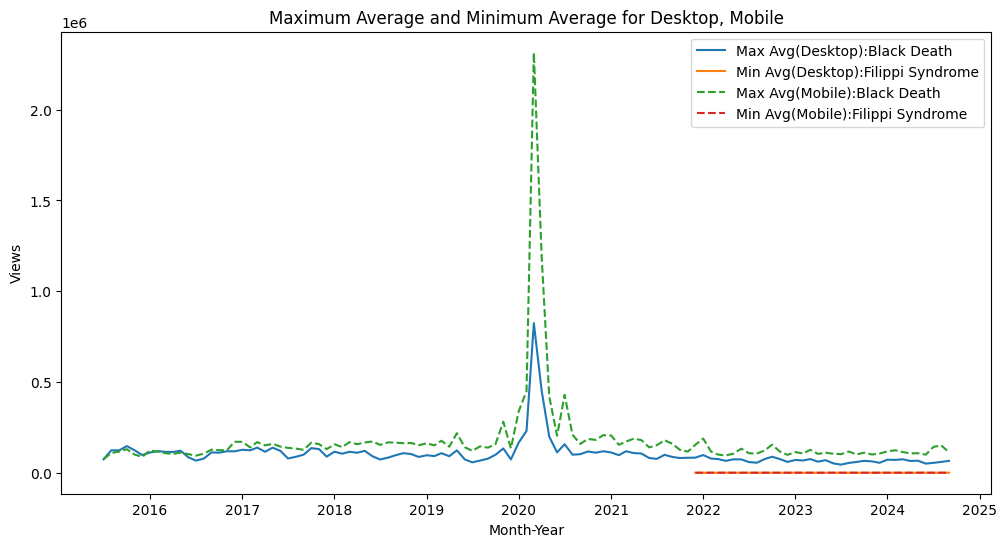

In [105]:
# Create a directory for saving the generated plots
dest_folder_plots = "article_views_stats_plots"
create_dir_if_not_exists(dest_folder_plots)

# Set plot size
plt.figure(figsize=(12,6))

# Plot a seperate line for each case
plt.plot(desktop_results['max_avg_article_df']["date"], desktop_results['max_avg_article_df']["views"], label="Max Avg(Desktop):" + desktop_results["max_avg_article_title"] )
plt.plot(desktop_results['min_avg_article_df']["date"], desktop_results['min_avg_article_df']["views"], label="Min Avg(Desktop):" + desktop_results["min_avg_article_title"])
plt.plot(mobile_results['max_avg_article_df']["date"], mobile_results['max_avg_article_df']["views"], label="Max Avg(Mobile):" + mobile_results["max_avg_article_title"], linestyle="dashed")
plt.plot(mobile_results['min_avg_article_df']["date"], mobile_results['min_avg_article_df']["views"], label="Min Avg(Mobile):" + mobile_results["min_avg_article_title"], linestyle="dashed")

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Month-Year')
plt.ylabel('Views')
plt.title('Maximum Average and Minimum Average for Desktop, Mobile')

# Add legend
plt.legend()

# Save plot as png
plt.savefig(f"{dest_folder_plots}/max_min_avg.png", bbox_inches='tight') 

# Show the plot
plt.show()


##### Analysis

From the graph above, we observe that the article on the disease "Black Death" has the highest average page requests on both desktop and mobile platforms. The number of views peaked in the early months of 2020. Additionally, during the month with the highest views, the article was viewed on mobile more than twice as often as on desktop.

In contrast, the article on "Filippi Syndrome" has the lowest average page requests on both desktop and mobile. The data for this article is not available prior to 2021.


2: Top 10 Peak Page Views: 
This graph contains time series for the top 10 article pages by largest (peak) page views over the entire time series by access type. To find the top 10, first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. The graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

Helper function is created to find the articles with max average views and min average views.

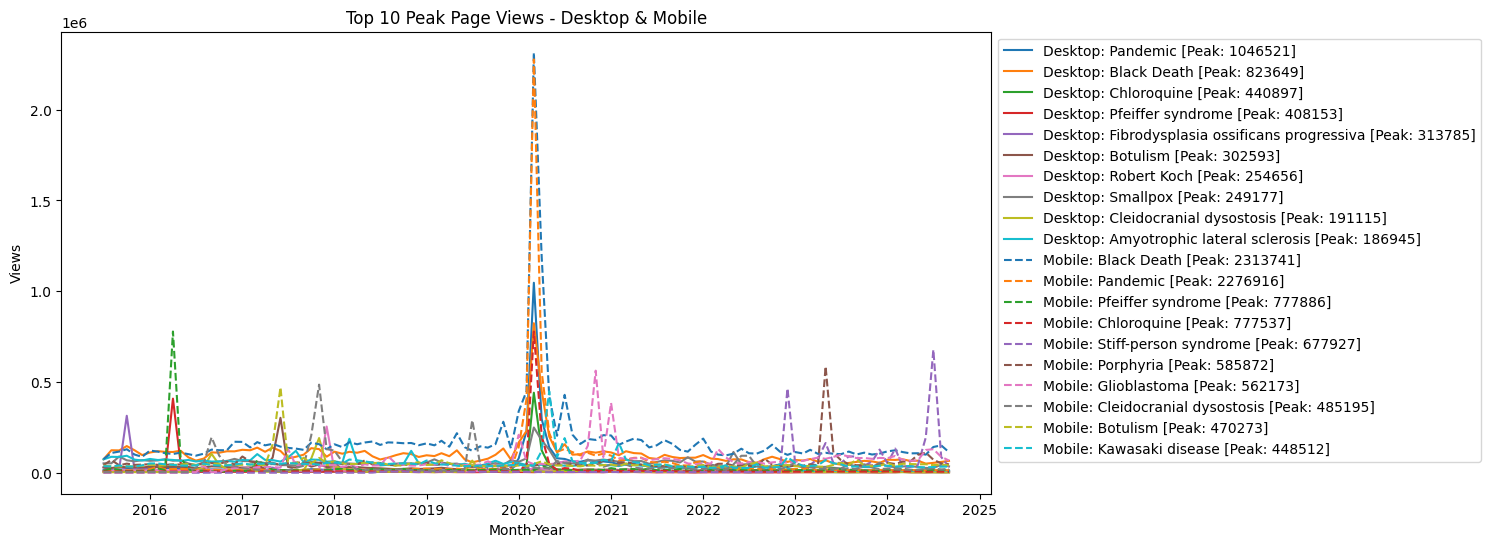

In [120]:

def get_top_10_by_peak_views(df):
    """
    Retrieves the top 10 articles with the highest peak views from the aggregated DataFrame.

    Args:
        df (pd.DataFrame): A DataFrame containing aggregated statistics for articles,
                           including max views and article data.

    Returns:
        pd.DataFrame: A DataFrame containing the top 10 articles with the highest peak views.
    """
    # Sort the DataFrame by max views in descending order and return the top 10 articles
    return df.sort_values(["max_views", "title"], ascending=False).head(10)


# Example usage with aggregated DataFrames for desktop and mobile views
# Assuming `desktop_aggregate_df` and `mobile_aggregate_df` are your DataFrames

# Process top 10 peaks for desktop and mobile data
top_10_desktop_df = get_top_10_by_peak_views(desktop_df)
top_10_mobile_df = get_top_10_by_peak_views(mobile_df)

# Set the plot size
plt.figure(figsize=(12, 6))

# ---- Plot Desktop Data ----
for index, row in top_10_desktop_df.iterrows():
    article_df = pd.DataFrame(row["view_data"])
    article_df['date'] = pd.to_datetime(article_df['timestamp'], format='%Y%m%d%H')
    plt.plot(article_df["date"], article_df["views"],
             label=f"Desktop: {row['title']} [Peak: {row['max_views']}]",
             linestyle="-")

# ---- Plot Mobile Data ----
for index, row in top_10_mobile_df.iterrows():
    article_df = pd.DataFrame(row["view_data"])
    article_df['date'] = pd.to_datetime(article_df['timestamp'], format='%Y%m%d%H')
    plt.plot(article_df["date"], article_df["views"],
             label=f"Mobile: {row['title']} [Peak: {row['max_views']}]",
             linestyle="--")

# Set labels and title
plt.xlabel('Month-Year')
plt.ylabel('Views')
plt.title('Top 10 Peak Page Views - Desktop & Mobile')

# Add legend
plt.legend(bbox_to_anchor=(1, 1))

# Save the plot as a PNG image
plt.savefig(f"{dest_folder_plots}/top_10_peak_page_views_combined.png", bbox_inches='tight')

# Display the plot
plt.show()



The legend beside the graph provides details about the article names, the access type (Desktop / Mobile) and the number of times it was viewed in the articles "most popular" month.

#### Analysis
From the above graph we can infer the following:
- There is a significant spike in page views around 2020 for both desktop and mobile access. This spike is most prominent for the "Pandemic" and "Black Death" articles. This may be related to the COVID-19 pandemic, as people were likely searching for information on pandemics and related topics during that time.
- Before and after the peak periods, the number of page views for most articles is relatively low and stable.
- Not all articles experience their peak views at the same time. For instance, articles like "Botulism" and "Kawasaki disease" show peaks at different time periods, likely indicating separate events or triggers that increased public interest in those topics.



3: Fewest Months of Data: This graph shows pages that have the fewest months of available data. It shows the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

A helper function is created to find the articles with max average views and min average views.


In [122]:
def fewest_months(aggregated_df):
    """
    Retrieves 10 articles with the fewest months of data from the aggregated DataFrame.

    Args:
        aggregated_df (pd.DataFrame): A DataFrame containing aggregated statistics 
                                       for articles, including average views.

    Returns:
        pd.dataframe: A dataframe containing 10 rows having fewest months of data, where each row is an article.
    """
    fewest_data = aggregated_df.sort_values(["total_views", "title"]).head(10)
    return fewest_data

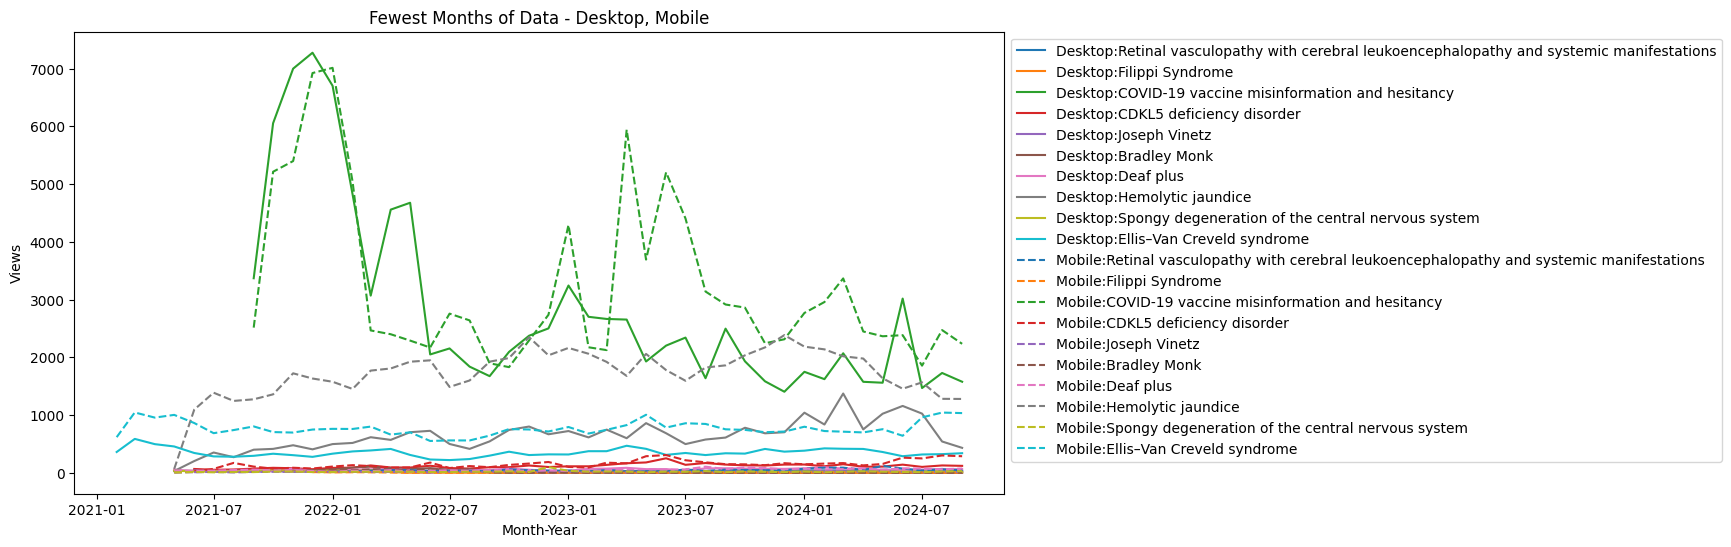

In [125]:
# Set plot size
plt.figure(figsize=(12,6))

# Process and plot 10 articles with fewest data for desktop data
fewest_months_desktop_df = fewest_months(desktop_df)
for index, row in fewest_months_desktop_df.iterrows():
    # Create temporary dataframe for each article
    temp_df = pd.DataFrame(row["view_data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot desktop data
    plt.plot(temp_df["date"], temp_df["views"], label="Desktop:" + row["title"] )

# Process and plot 10 articles with fewest data for mobile data
fewest_months_mobile_df = fewest_months(mobile_df)
for index, row in fewest_months_mobile_df.iterrows():
    # Create temporary dataframe for each article
    temp_df = pd.DataFrame(row["view_data"])
    # Convert timestamp to datetime
    temp_df['date'] = pd.to_datetime(temp_df['timestamp'], format='%Y%m%d%H')
    # Plot mobile data with dashed lines
    plt.plot(temp_df["date"], temp_df["views"], label="Mobile:" + row["title"], linestyle='dashed' )

# Set the X-axis and Y axis labels, along with the title of the plot.
plt.xlabel('Month-Year')
plt.ylabel('Views')
plt.title('Fewest Months of Data - Desktop, Mobile')

# Add legend to distinguish between different lines
plt.legend(bbox_to_anchor=(1, 1))

# Save plot as png
plt.savefig(f"{dest_folder_plots}/fewest_months_of_data.png", bbox_inches='tight') 

# Display the plot
plt.show()

#### Analysis

- The article COVID-19 vaccine misinformation and hesitancy has the biggest peak around later months of 2021 for both desktop and mobile but overtime the desktop views seems to diminish with a few peaks and dips still occuring for the mobile views.
- Majorly the desktop views for these articles seem to be very low compared to the mobile views this could be because of easy of accessibility of a mobile compared to a desktop.
- Many articles, such as "CDKL5 deficiency disorder," "Deaf plus," and "Hemolytic jaundice," have consistently low page views throughout the timeline, both on desktop and mobile. These articles likely cater to niche topics that haven't garnered widespread attention.
- The data only spans from around 2021 onwards, with viewership peaking mostly around 2022, and tapering off for several articles by mid-2023. 